In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

data = pd.read_csv("preprocessed_apartment_rentals_clusters.csv")
# Beispiel-Daten (ersetze X, y durch deine Daten)
features = data.drop(columns=["price", "cityname", "state"]).columns
print(features)
X, y = data.drop(columns=["price", "cityname", "state"]).values, data["price"].values
scaler = StandardScaler()
#scaler = MinMaxScaler
X = scaler.fit_transform(X)

Index(['bathrooms', 'bedrooms', 'has_photo', 'square_feet', 'latitude',
       'longitude', 'time', 'pool', 'gym', 'parking', 'sauna', 'elevator',
       'clubhouse', 'source_Andere source', 'source_GoSection8',
       'source_ListedBuy', 'source_RealRentals', 'source_RentDigs.com',
       'source_RentLingo', 'state_AK', 'state_AL', 'state_AR', 'state_AZ',
       'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL',
       'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN',
       'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME',
       'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC',
       'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV',
       'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI',
       'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA',
       'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY', 'cluster_0',
       '

# Regression

In [2]:

import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


# Nested CV Parameter
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Hyperparameter-Suche im inneren CV
param_grid = {"alpha": np.logspace(-3, 3, 20)}
model = Ridge()

grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=inner_cv,
    scoring="neg_mean_squared_error",
    n_jobs=1
)

outer_mse = []
outer_r2 = []
best_params_per_fold = []

for train_ix, test_ix in outer_cv.split(X):
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    
    # Inner CV + Fit
    grid_search.fit(X_train, y_train)
    
    # Bestes Modell bewerten
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    outer_mse.append(mse)
    outer_r2.append(r2)
    best_params_per_fold.append(grid_search.best_params_)
print("Outer MSE Scores:", outer_mse)
print("Mean MSE:", np.mean(outer_mse))
print("Std MSE:", np.std(outer_mse))
print("Outer R² Scores:", outer_r2)
print("Mean R²:", np.mean(outer_r2))
print("Best params", best_params_per_fold)



Outer MSE Scores: [218490.50167903118, 214575.06273971553, 215577.7280298093, 220096.13097939227, 215098.6776672528]
Mean MSE: 216767.6202190402
Std MSE: 2147.3623527603345
Outer R² Scores: [0.538220142353645, 0.5391803458701592, 0.534067536249452, 0.5350063530970879, 0.5280598269507408]
Mean R²: 0.534906840904217
Best params [{'alpha': np.float64(26.366508987303554)}, {'alpha': np.float64(26.366508987303554)}, {'alpha': np.float64(26.366508987303554)}, {'alpha': np.float64(12.742749857031322)}, {'alpha': np.float64(26.366508987303554)}]


In [3]:
ridge = Ridge(alpha=26.0)  # Standard Alpha, kann angepasst werden

# 5️⃣ Modell auf allen Daten fitten
ridge.fit(X, y)
y_pred = ridge.predict(X)
print(r2_score(y, y_pred))


importance = pd.Series(ridge.coef_, index= features)
importance = importance.sort_values(key=abs, ascending=False)
print("\nFeature Importances (absolut sortiert):")
print(importance)

0.5358008953007783

Feature Importances (absolut sortiert):
square_feet             215.444125
latitude                171.893677
state_CA                164.990874
cluster_12              138.563577
cluster_2              -136.251797
                           ...    
state_MS                 -3.776731
source_Andere source      2.530247
state_TN                  0.945672
cluster_14                0.847723
sauna                     0.000000
Length: 90, dtype: float64


# Teste verschiedene Modelle

In [2]:
from Nested_CV import NestedCVRegressor

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.1s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END .........................alpha=0.004641588833612777; total time=   0.1s
[CV] END .........................alpha=0.004641588833612777; total time=   0.1s
[CV] END .........................alpha=0.004641588833612777; total time=   0.1s
[CV] END .........................alpha=0.004641588833612777; total time=   0.1s
[CV] END .........................alpha=0.004641588833612777; total time=   0.1s
[CV] END .........................alpha=0.021544346900318832; total time=   0.1s
[CV] END .........................alpha=0.021544

c:\Users\User\Git\DataProject-WS-25-26\Nested_CV.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


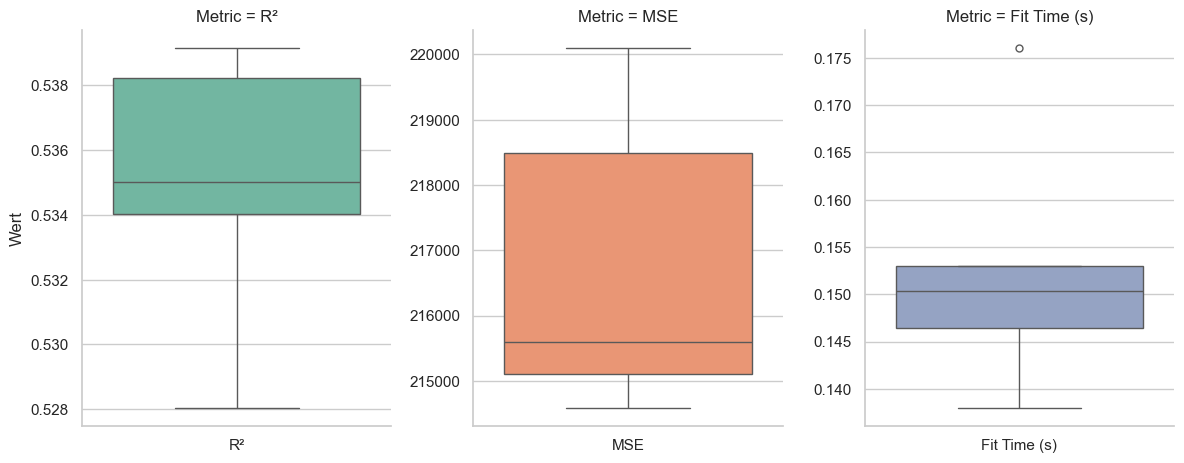

In [3]:
from sklearn.linear_model import Ridge

ridge_params = {"alpha": np.logspace(-3, 3, 10)}

ridge_cv = NestedCVRegressor(Ridge(), ridge_params)
ridge_cv.run(X, y, output=True)

print("Ridge Mean R²:", ridge_cv.get_mean_r2())
print("Ridge best params:", ridge_cv.get_best_params())

ridge_cv.plot_scores("Ridge Nested CV")


In [5]:
number_outer_cv_splits = 5
model_evaluation = pd.DataFrame({"Fold": range(1, number_outer_cv_splits+1)})
model_evaluation['Modell'] = ['Ridge'] * number_outer_cv_splits
model_evaluation['R_2'] = ridge_cv.get_r2_scores()
model_evaluation['MSE'] = ridge_cv.get_mse_scores()
model_evaluation["runtime"] = ridge_cv.get_fit_times()
model_evaluation

,Fold,Modell,R_2,MSE,runtime
0,1,Ridge,0.538214,218493.376736,0.137990
1,2,Ridge,0.539156,214586.485500,0.146456
2,3,Ridge,0.534041,215589.832600,0.153025
3,4,Ridge,0.535002,220098.240192,0.150380
4,5,Ridge,0.528040,215107.861255,0.176054


In [7]:
model_evaluation.to_pickle('benchmarking/Ridgeregression.pkl')

# Analyse
Welche Preise werden gut, welche schlechter vorhergesagt?

Final Alpha: 31.84953300167664


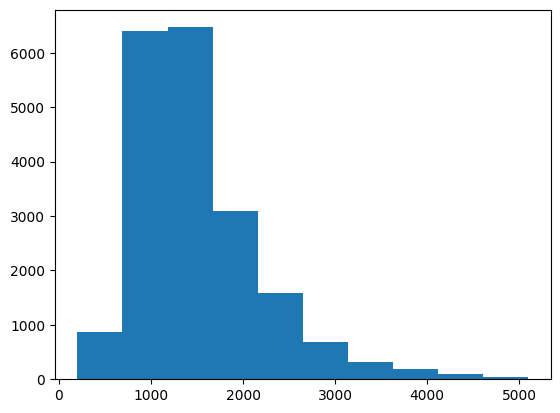

Test MSE: 216997.1830429842
Test R²: 0.5411112717586275


C:\Users\User\AppData\Local\Temp\ipykernel_20456\1634005072.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


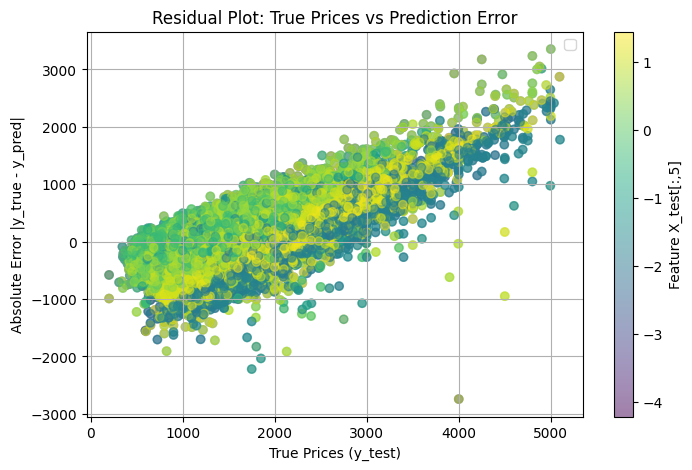

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1️⃣ Best Alpha aus Nested CV
best_parameters = ridge_cv.get_best_params()
alpha_values = [float(d['alpha']) for d in best_parameters]
mean_alpha = np.mean(alpha_values)
print("Final Alpha:", mean_alpha)


# 2️⃣ Daten splitten
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
plt.hist(y_test)
plt.show()
# 3️⃣ Finales Ridge-Modell trainieren
final_model = Ridge(alpha=mean_alpha)
final_model.fit(X_train, y_train)

# 4️⃣ Vorhersagen auf Testdaten
y_pred = final_model.predict(X_test)

# 5️⃣ Scores berechnen
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test MSE:", mse)
print("Test R²:", r2)

# 6️⃣ Residual Plot: echte Preise vs absolute Fehler
abs_error = y_test - y_pred

plt.figure(figsize=(8,5))
plt.scatter(y_test, abs_error, c= X_test[:,1], alpha=0.5)
scatter = plt.scatter(y_test, abs_error, c=X_test[:,5], alpha=0.5, cmap='viridis')
plt.xlabel("True Prices (y_test)")
plt.ylabel("Absolute Error |y_true - y_pred|")
plt.title("Residual Plot: True Prices vs Prediction Error")
plt.grid(True)
plt.legend()
cbar = plt.colorbar(scatter)
cbar.set_label('Feature X_test[:,5]')
plt.show()

